In [1]:
import scipy
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

In [2]:
def load_data(path_npz):
    """Return the data from path_npz.

    Parameters
    ----------
    path_npz : str
        Path to *.npz file containing reaction data.
 
    """

    # load data
    data = np.load(path_npz)

    # check consistency of data arrays shape

    # check_data_consistency(data)

    print(f"{path_npz} number of data points: {data['Z'].shape[0]}")

    # # get data corresponding to reaction
    # data = get_data_subset(data, rxn_num[3:])

    # # remove appended zero to data arrays

    # data = get_data_remove_appended_zero(data)

    # get unique reaction numbers included in data
    rxn_nums = np.unique(data['RXN'])
    print(f"{path_npz} reactions: {rxn_nums}")

    # only use the first reaction if there are multiple
    rxn_num = f"rxn{rxn_nums[0]}"

    # from parse():
        #     Returns
        # -------
        # dict: A dictionary with following keys:
        #     'R': positions, array of (n_snapshots, n_atoms, 3)
        #     'Z': atomic numbers, array of (n_snapshots, n_atoms)
        #     'E': energy, array of (n_snapshots, 1)
        #     'F': forces, array of (n_snapshots, n_atoms, 3)


    # # coords: ndarray, shape=(M, N, 3)
    # #     The 3D array of atomic coordinates for M data points and N atoms.
    # R_data = data['R']
    # print(f"R shape: {R_data.shape}")
    # print(R_data[0])

    #     nums : ndarray, shape=(M, N)
    #     The 2D array of atomic numbers for M data points and N atoms
    Z_data = data['Z']
    print(f"Z shape: {Z_data.shape}")
    print(Z_data[0])
    
    # # nmber of atoms??
    # N_data = data['N']
    # print(f"N shape: {N_data.shape}")
    # print(N_data[0])

    # # energy
    # E_data = data['E']
    # print(f"E shape: {E_data.shape}")
    # print(E_data[0])

    # # force
    # F_data = data['F']
    # print(f"F shape: {F_data.shape}")
    # print(F_data[0])

    # # reaction numbers??
    # RXN_data = data['RXN']
    # print(f"RXN shape: {RXN_data.shape}")
    # print(RXN_data[0])


    # NOTE: it appears that the "coordination numbers" used as an axis here are the typical
    # chemical meaning of coordination number. The coordination number is larger where the
    # pairwise distance is smaller, following a Fermi-Dirac distribution. The `dist` variable
    # tells it which atoms to look at. 
    # # get reaction data
    # cn1s = rxn_dict[rxn_num]['cn1']
    # cn2s = rxn_dict[rxn_num]['cn2']
    # mu = rxn_dict[rxn_num]['mu']

    # # make namedtuple for plotting
    # cn1 = get_cn_arrays(data['Z'], data['R'], cn1s, mu=mu[0], sigma=3.0)
    # cn2 = get_cn_arrays(data['Z'], data['R'], cn2s, mu=mu[1], sigma=3.0)
    # data_namedtuple = get_rxn_namedtuple(cn1, cn2, data['E'].flatten())

    # return data_namedtuple, rxn_num

    return data

In [3]:
def torsion(xyzs, i, j, k):
    # compute the torsion angle for atoms i,j,k
    ibeg = (i - 1) * 3
    iend = i * 3
    jbeg = (j - 1) * 3
    jend = j * 3
    kbeg = (k - 1) * 3
    kend = k * 3

    rij = xyzs[ibeg:iend] - xyzs[jbeg:jend]
    rkj = xyzs[kbeg:kend] - xyzs[jbeg:jend]
    cost = np.sum(rij * rkj)
    sint = la.norm(np.cross(rij, rkj))
    angle = np.arctan2(sint, cost)
    return angle

In [4]:
def cart2zmat(X):
    X = X.T
    nrows, ncols = X.shape
    na = nrows // 3
    Z = []

    for j in range(ncols):
        rlist = []  # list of bond lengths
        alist = []  # list of bond angles (radian)
        dlist = []  # list of dihedral angles (radian)
        # calculate the distance matrix between atoms
        distmat = np.zeros((na, na))
        for jb in range(na):
            jbeg = jb * 3
            jend = (jb + 1) * 3
            xyzb = X[jbeg:jend, j]
            for ia in range(jb + 1, na):
                ibeg = ia * 3
                iend = (ia + 1) * 3
                xyza = X[ibeg:iend, j]
                distmat[ia, jb] = la.norm(xyza - xyzb)
        distmat = distmat + np.transpose(distmat)

        if na > 1:
            rlist.append(distmat[0, 1])

        if na > 2:
            rlist.append(distmat[0, 2])
            alist.append(torsion(X[:, j], 3, 1, 2))

        Z.append(rlist + alist + dlist)

    Z = np.array(Z)
    return Z.T

In [5]:
data = load_data('../H2COMBUSTION_DATA-main-2/09_aimd.npz')

all_data = data['R'][:,0:3,:]
input_data = np.reshape(data['R'][:,0:3,:], (10000,9))

relative_data = cart2zmat(input_data).T

data0 = relative_data[0]
data_final = relative_data[-1]

print(data_final.shape)

print(data0)
print(data_final)

../H2COMBUSTION_DATA-main-2/09_aimd.npz number of data points: 10000
../H2COMBUSTION_DATA-main-2/09_aimd.npz reactions: ['09']
Z shape: (10000, 6)
[8 8 1 0 0 0]
(3,)
[1.20143702 1.84665626 2.01986071]
[1.23486699 2.7058309  1.87322554]


In [6]:
ircdata = scipy.io.loadmat('./irc09.mat')['irc09'][0][0][3]
print(ircdata.shape)

relative_ircdata = cart2zmat(ircdata.T)

print(relative_ircdata.shape)
x0 = relative_ircdata[:, 0].T
print(x0)
xfinal = relative_ircdata[:, -1].T
print(xfinal)

(9, 60)
(3, 60)
[1.31554356 0.97372541 1.84223432]
[1.1977229  2.4081915  1.96424919]


In [11]:
traj_ae_1 = np.loadtxt('trajectories_AE_1.txt', delimiter=',')
traj_pca_1 = np.loadtxt('trajectories_PCA_1.txt', delimiter=',')

# traj_ae_2 = np.loadtxt('trajectories_AE_2.txt', delimiter=',')
# traj_pca_2 = np.loadtxt('trajectories_PCA_2.txt', delimiter=',')

# traj_ae_3 = np.loadtxt('trajectories_AE_3.txt', delimiter=',')
# traj_pca_3 = np.loadtxt('trajectories_PCA_3.txt', delimiter=',')

all_traj_ae = [np.loadtxt(f'trajectories_AE_{i+1}.txt', delimiter=',') for i in range(10)]
all_traj_pca = [np.loadtxt(f'trajectories_PCA_{i+1}.txt', delimiter=',') for i in range(10)]

# all_traj_ae = [np.loadtxt(f'trajectories_AE_{i+1}.txt', delimiter=',') for i in range(10)]

In [12]:
print(traj_ae_1.shape)
print(traj_pca_1.shape)

all_traj_ae_relative = [cart2zmat(traj_ae_i).T for traj_ae_i in all_traj_ae]
all_traj_pca_relative = [cart2zmat(traj_pca_i).T for traj_pca_i in all_traj_pca]

traj_ae_relative_1 = cart2zmat(traj_ae_1).T
traj_pca_relative_1 = cart2zmat(traj_pca_1).T

# traj_ae_relative_2 = cart2zmat(traj_ae_2).T
# traj_pca_relative_2 = cart2zmat(traj_pca_2).T

# traj_ae_relative_3 = cart2zmat(traj_ae_3).T
# traj_pca_relative_3 = cart2zmat(traj_pca_3).T

print(traj_ae_relative_1.shape)
print(traj_pca_relative_1.shape)

(1001, 9)
(1001, 9)
(1001, 3)
(1001, 3)


In [13]:
# Two arrays that are [dist1, dist2, angle]
# Calculates the cosine similarity of these, ignoring that the units of angle and distances are different. 
def dist_between(arr1, arr2):
    # atoms1 = arr1.reshape((3,3))
    # atoms2 = arr2.reshape((3,3))
    # total_dist = 0.0
    # for i in range(3):
    #     total_dist += np.linalg.norm(atoms1[i] - atoms2[i])
    total_dist = np.linalg.norm(arr1 - arr2)

    return total_dist



Text(0, 0.5, "'Distance' From IRC Final Position")

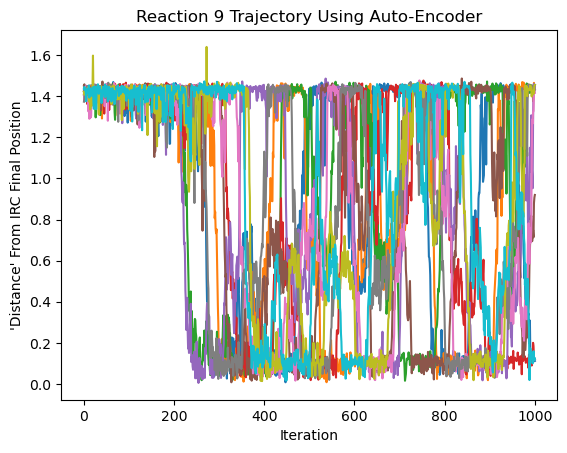

In [14]:
ae_dists_to_final = [dist_between(elem, xfinal) for elem in traj_ae_relative_1]
# ae_dists_to_final_2 = [dist_between(elem, xfinal) for elem in traj_ae_relative_2]
# ae_dists_to_final_3 = [dist_between(elem, xfinal) for elem in traj_ae_relative_3]

all_ae_dists_to_final = [[dist_between(elem, xfinal) for elem in traj] for traj in all_traj_ae_relative]

for data in all_ae_dists_to_final:
    plt.plot(data)
# plt.plot(ae_dists_to_final)
plt.title('Reaction 9 Trajectory Using Auto-Encoder')
plt.xlabel('Iteration')
plt.ylabel('\'Distance\' From IRC Final Position')

Text(0, 0.5, "'Distance' From IRC Final Position")

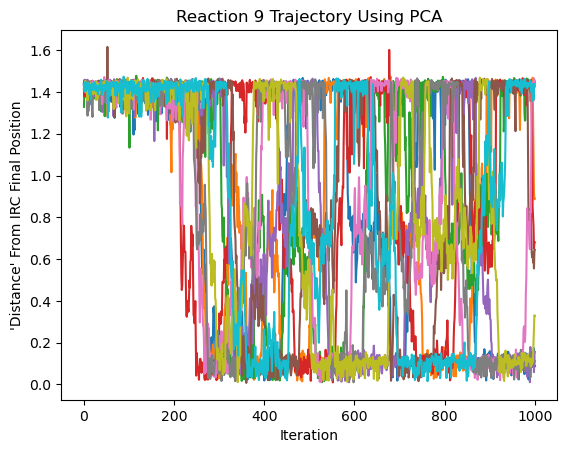

In [15]:
pca_dists_to_final = [dist_between(elem, xfinal) for elem in traj_pca_relative_1]
# pca_dists_to_final_2 = [dist_between(elem, xfinal) for elem in traj_pca_relative_2]
# pca_dists_to_final_3 = [dist_between(elem, xfinal) for elem in traj_pca_relative_3]

all_pca_dists_to_final = [[dist_between(elem, xfinal) for elem in traj] for traj in all_traj_pca_relative]

for data in all_pca_dists_to_final:
    plt.plot(data)
# plt.plot(pca_dists_to_final)
plt.title('Reaction 9 Trajectory Using PCA')
plt.xlabel('Iteration')
plt.ylabel('\'Distance\' From IRC Final Position')

Text(0, 0.5, "'Distance' From IRC Initial Position")

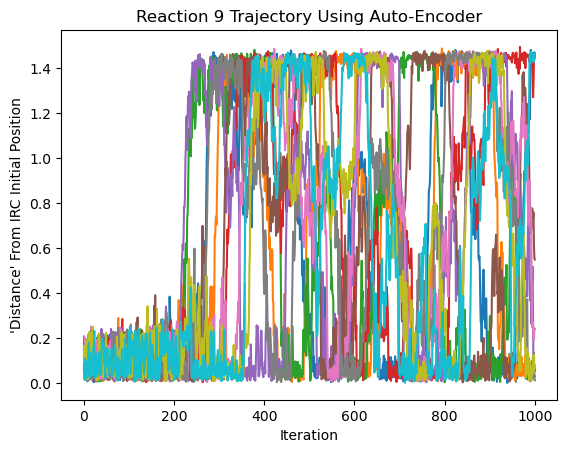

In [16]:
ae_dists_to_start = [dist_between(elem, x0) for elem in traj_ae_relative_1]
# ae_dists_to_start_2 = [dist_between(elem, x0) for elem in traj_ae_relative_2]
# ae_dists_to_start_3 = [dist_between(elem, x0) for elem in traj_ae_relative_3]

all_ae_dists_to_start = [[dist_between(elem, x0) for elem in traj] for traj in all_traj_ae_relative]

for data in all_ae_dists_to_start:
    plt.plot(data)
# plt.plot(ae_dists_to_start)
plt.title('Reaction 9 Trajectory Using Auto-Encoder')
plt.xlabel('Iteration')
plt.ylabel('\'Distance\' From IRC Initial Position')

Text(0, 0.5, "'Distance' From IRC Initial Position")

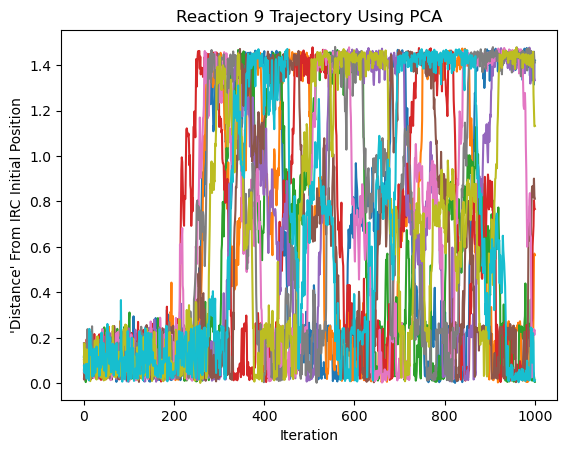

In [17]:
pca_dists_to_start = [dist_between(elem, x0) for elem in traj_pca_relative_1]
# pca_dists_to_start_2 = [dist_between(elem, x0) for elem in traj_pca_relative_2]
# pca_dists_to_start_3 = [dist_between(elem, x0) for elem in traj_pca_relative_3]

all_pca_dists_to_start = [[dist_between(elem, x0) for elem in traj] for traj in all_traj_pca_relative]

# plt.plot(pca_dists_to_start)
for data in all_pca_dists_to_start:
    plt.plot(data)
plt.title('Reaction 9 Trajectory Using PCA')
plt.xlabel('Iteration')
plt.ylabel('\'Distance\' From IRC Initial Position')

Text(0, 0.5, "'Distance' From the Origin")

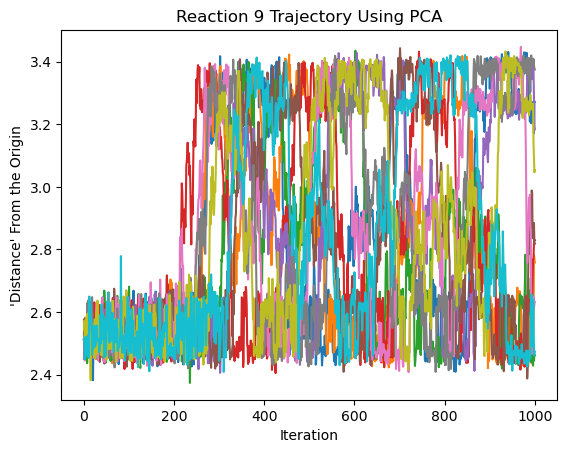

In [18]:
origin = [0,0,0]
pca_dists_to_origin = [dist_between(elem, origin) for elem in traj_pca_relative_1]
# pca_dists_to_origin_2 = [dist_between(elem, origin) for elem in traj_pca_relative_2]
# pca_dists_to_origin_3 = [dist_between(elem, origin) for elem in traj_pca_relative_3]

all_pca_dists_to_origin = [[dist_between(elem, origin) for elem in traj] for traj in all_traj_pca_relative]

for data in all_pca_dists_to_origin:
    plt.plot(data)
# plt.plot(pca_dists_to_origin)
plt.title('Reaction 9 Trajectory Using PCA')
plt.xlabel('Iteration')
plt.ylabel('\'Distance\' From the Origin')

Text(0, 0.5, "'Distance' From the Origin")

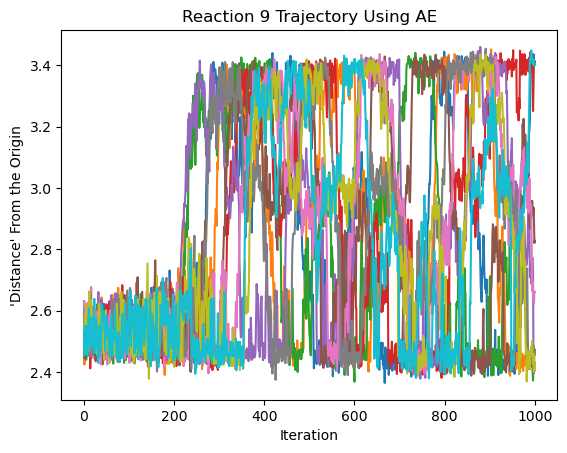

In [19]:
ae_dists_to_origin = [dist_between(elem, origin) for elem in traj_ae_relative_1]
# ae_dists_to_origin_2 = [dist_between(elem, origin) for elem in traj_ae_relative_2]
# ae_dists_to_origin_3 = [dist_between(elem, origin) for elem in traj_ae_relative_3]
all_ae_dists_to_origin = [[dist_between(elem, origin) for elem in traj] for traj in all_traj_ae_relative]

# plt.plot(ae_dists_to_origin)
for data in all_ae_dists_to_origin:
    plt.plot(data)
plt.title('Reaction 9 Trajectory Using AE')
plt.xlabel('Iteration')
plt.ylabel('\'Distance\' From the Origin')

In [20]:
def find_first_index_below(vals, value):
    for i in range(len(vals)):
        if vals[i] < value:
            return i
    return len(vals)

def find_first_index_above(vals, value):
    for i in range(len(vals)):
        if vals[i] > value:
            return i
    return len(vals)

In [21]:
ae_start_indices = [find_first_index_above(elem, 1.3) for elem in all_ae_dists_to_start]
pca_start_indices = [find_first_index_above(elem, 1.3) for elem in all_pca_dists_to_start]

ae_final_indices = [find_first_index_below(elem, 0.2) for elem in all_ae_dists_to_final]
pca_final_indices = [find_first_index_below(elem, 0.2) for elem in all_pca_dists_to_final]

ae_origin_indices = [find_first_index_above(elem, 3.2) for elem in all_ae_dists_to_origin]
pca_origin_indices = [find_first_index_above(elem, 3.2) for elem in all_pca_dists_to_origin]

print('Iters to Escape Start')
print(f'AE: {ae_start_indices}')
print(f'PCA: {pca_start_indices}')
print(f'AE mean: {np.mean(ae_start_indices)} +/- {np.std(ae_start_indices)}')
print(f'PCA mean: {np.mean(pca_start_indices)} +/- {np.std(pca_start_indices)}')

print('Iters to Find End')
print(f'AE: {ae_final_indices}')
print(f'PCA: {pca_final_indices}')
print(f'AE mean: {np.mean(ae_final_indices)} +/- {np.std(ae_final_indices)}')
print(f'PCA mean: {np.mean(pca_final_indices)} +/- {np.std(pca_final_indices)}')

print('Iters to Change Minima')
print(f'AE: {ae_origin_indices}')
print(f'PCA: {pca_origin_indices}')
print(f'AE mean: {np.mean(ae_origin_indices)} +/- {np.std(ae_origin_indices)}')
print(f'PCA mean: {np.mean(pca_origin_indices)} +/- {np.std(pca_origin_indices)}')

# print(find_first_index_above(ae_dists_to_start, 1.3))
# print(find_first_index_above(pca_dists_to_start, 1.3))

# print(find_first_index_below(ae_dists_to_final, 0.2))
# print(find_first_index_below(pca_dists_to_final, 0.2))

# print(find_first_index_above(ae_dists_to_origin, 3.2))
# print(find_first_index_above(pca_dists_to_origin, 3.2))

Iters to Escape Start
AE: [279, 299, 242, 339, 238, 321, 374, 281, 379, 371]
PCA: [274, 271, 323, 249, 332, 345, 267, 275, 295, 342]
AE mean: 312.3 +/- 50.217626387554404
PCA mean: 297.3 +/- 33.35580908927259
Iters to Find End
AE: [279, 299, 242, 339, 231, 321, 368, 281, 378, 371]
PCA: [273, 271, 321, 249, 332, 345, 267, 275, 294, 333]
AE mean: 310.9 +/- 50.448885022366944
PCA mean: 296.0 +/- 32.155870381627054
Iters to Change Minima
AE: [278, 299, 242, 339, 231, 321, 366, 279, 373, 371]
PCA: [272, 271, 321, 245, 332, 344, 267, 275, 296, 333]
AE mean: 309.9 +/- 49.758315887899585
PCA mean: 295.6 +/- 32.67476090195611
